# QUESTION 1.2.2

## IMPORTS & SETUP

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, poisson

# Load the data
data = np.loadtxt("premier_league_2013_2014.dat", delimiter=",")

## Log-likelihood and log-prior helper functions

In [12]:

y_g1 = data[:, 0]  # Goals scored by home team
y_g2 = data[:, 1]  # Goals scored by away team
h_g = data[:, 2].astype(int)  # Home team index
a_g = data[:, 3].astype(int)  # Away team index

# Parameters
n_teams = 20
n_games = len(data)
tau_0 = 0.0001  # Prior precision for home
tau_1 = 0.0001  # Prior precision for mean parameters
alpha = 0.1     # Gamma shape parameter
beta = 0.1      # Gamma rate parameter

# Set up parameter vector
# Order: home, att_1,...,att_19, def_1,...,def_19, mu_att, mu_def, tau_att, tau_def
n_params = 1 + (n_teams-1) + (n_teams-1) + 4  # home + att + def + hyperparams
att_start_idx = 1
def_start_idx = att_start_idx + (n_teams-1)
hyper_start_idx = def_start_idx + (n_teams-1)

def log_likelihood(params):
    """Compute log likelihood of the data given parameters."""
    home = params[0]
    att = np.zeros(n_teams)
    att[1:] = params[att_start_idx:def_start_idx]  # att_0 = 0
    
    def_ = np.zeros(n_teams)
    def_[1:] = params[def_start_idx:hyper_start_idx]  # def_0 = 0
    
    mu_att = params[hyper_start_idx]
    mu_def = params[hyper_start_idx + 1]
    tau_att = params[hyper_start_idx + 2]
    tau_def = params[hyper_start_idx + 3]
    
    # Ensure tau parameters are positive
    if tau_att <= 0 or tau_def <= 0:
        return -np.inf
    
    # Calculate theta values
    log_theta_g1 = home + att[h_g] - def_[a_g]
    log_theta_g2 = att[a_g] - def_[h_g]
    
    theta_g1 = np.exp(log_theta_g1)
    theta_g2 = np.exp(log_theta_g2)
    
    # Log likelihood for observed goals
    ll_goals = np.sum(poisson.logpmf(y_g1, theta_g1) + poisson.logpmf(y_g2, theta_g2))
    
    # Log prior for home
    ll_home = norm.logpdf(home, 0, np.sqrt(1/tau_0))
    
    # Log prior for attack parameters
    ll_att = np.sum(norm.logpdf(att[1:], mu_att, np.sqrt(1/tau_att)))
    
    # Log prior for defense parameters
    ll_def = np.sum(norm.logpdf(def_[1:], mu_def, np.sqrt(1/tau_def)))
    
    # Log hyperpriors
    ll_mu_att = norm.logpdf(mu_att, 0, np.sqrt(1/tau_1))
    ll_mu_def = norm.logpdf(mu_def, 0, np.sqrt(1/tau_1))
    ll_tau_att = gamma.logpdf(tau_att, alpha, scale=1/beta)
    ll_tau_def = gamma.logpdf(tau_def, alpha, scale=1/beta)
    
    return ll_goals + ll_home + ll_att + ll_def + ll_mu_att + ll_mu_def + ll_tau_att + ll_tau_def


## MCMC function

In [13]:

def metropolis_hastings(n_burn, n_samples, thin, sigma):
    """
    Run Metropolis-Hastings algorithm.
    
    Args:
        n_burn: Number of burn-in samples
        n_samples: Number of samples to collect after burn-in
        thin: Thinning factor (keep every thin-th sample)
        sigma: Standard deviation for isotropic Gaussian proposal
    
    Returns:
        burn_samples: Samples from burn-in phase
        samples: Collected samples after burn-in
    """
    # Initialize parameters at 0
    current_params = np.zeros(n_params)
    current_params[hyper_start_idx + 2] = 1.0  # tau_att init
    current_params[hyper_start_idx + 3] = 1.0  # tau_def init
    
    current_ll = log_likelihood(current_params)
    
    # Store burn-in samples
    burn_samples = np.zeros((n_burn, n_params))
    
    # Burn-in phase
    for i in range(n_burn):
        # Propose new parameters
        proposal = current_params + np.random.normal(0, sigma, n_params)
        
        # Handle tau parameters to ensure they're positive
        if proposal[hyper_start_idx + 2] <= 0:
            proposal[hyper_start_idx + 2] = np.abs(proposal[hyper_start_idx + 2])
        if proposal[hyper_start_idx + 3] <= 0:
            proposal[hyper_start_idx + 3] = np.abs(proposal[hyper_start_idx + 3])
        
        # Compute log likelihood of proposal
        proposal_ll = log_likelihood(proposal)
        
        # Accept/reject step
        log_accept_ratio = proposal_ll - current_ll
        
        if np.log(np.random.random()) < log_accept_ratio:
            current_params = proposal
            current_ll = proposal_ll
        
        burn_samples[i] = current_params
        
        if (i+1) % 1000 == 0:
            print(f"Burn-in iteration {i+1}/{n_burn}")
    
    # Collect samples with thinning
    total_iter = n_samples * thin
    samples = np.zeros((n_samples, n_params))
    
    for i in range(total_iter):
        # Propose new parameters
        proposal = current_params + np.random.normal(0, sigma, n_params)
        
        # Handle tau parameters to ensure they're positive
        if proposal[hyper_start_idx + 2] <= 0:
            proposal[hyper_start_idx + 2] = np.abs(proposal[hyper_start_idx + 2])
        if proposal[hyper_start_idx + 3] <= 0:
            proposal[hyper_start_idx + 3] = np.abs(proposal[hyper_start_idx + 3])
        
        # Compute log likelihood of proposal
        proposal_ll = log_likelihood(proposal)
        
        # Accept/reject step
        log_accept_ratio = proposal_ll - current_ll
        
        if np.log(np.random.random()) < log_accept_ratio:
            current_params = proposal
            current_ll = proposal_ll
        
        # Store sample if it's a thinning iteration
        if (i+1) % thin == 0:
            samples[(i+1)//thin - 1] = current_params
        
        if (i+1) % 1000 == 0:
            print(f"Sampling iteration {i+1}/{total_iter}")
    
    return burn_samples, samples

## Running the code

Burn-in iteration 1000/5000
Burn-in iteration 2000/5000
Burn-in iteration 3000/5000
Burn-in iteration 4000/5000
Burn-in iteration 5000/5000
Sampling iteration 1000/25000
Sampling iteration 2000/25000
Sampling iteration 3000/25000
Sampling iteration 4000/25000
Sampling iteration 5000/25000
Sampling iteration 6000/25000
Sampling iteration 7000/25000
Sampling iteration 8000/25000
Sampling iteration 9000/25000
Sampling iteration 10000/25000
Sampling iteration 11000/25000
Sampling iteration 12000/25000
Sampling iteration 13000/25000
Sampling iteration 14000/25000
Sampling iteration 15000/25000
Sampling iteration 16000/25000
Sampling iteration 17000/25000
Sampling iteration 18000/25000
Sampling iteration 19000/25000
Sampling iteration 20000/25000
Sampling iteration 21000/25000
Sampling iteration 22000/25000
Sampling iteration 23000/25000
Sampling iteration 24000/25000
Sampling iteration 25000/25000


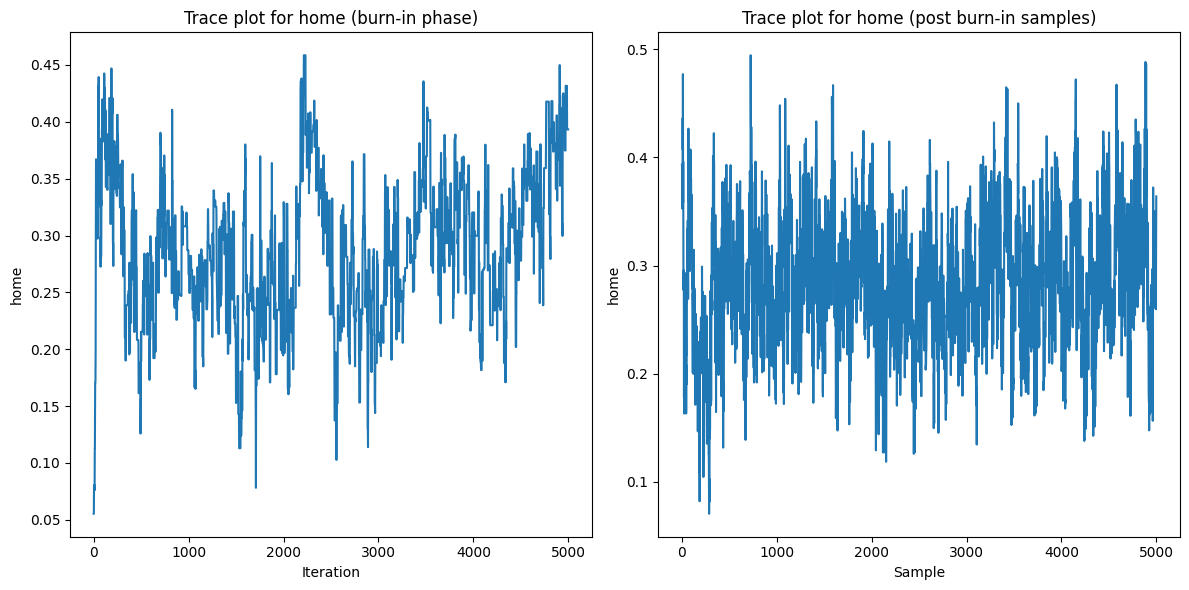

Estimated posterior mean of home: 0.2837


In [14]:
# Run MCMC
n_burn = 5000
n_samples = 5000
thin = 5
sigma = 0.05

burn_samples, samples = metropolis_hastings(n_burn, n_samples, thin, sigma)

# Plot trace plot for home parameter (first parameter)
plt.figure(figsize=(12, 6))

# Burning phase
plt.subplot(1, 2, 1)
plt.plot(range(n_burn), burn_samples[:, 0])
plt.title('Trace plot for home (burn-in phase)')
plt.xlabel('Iteration')
plt.ylabel('home')

# Post burn-in samples
plt.subplot(1, 2, 2)
plt.plot(range(n_samples), samples[:, 0])
plt.title('Trace plot for home (post burn-in samples)')
plt.xlabel('Sample')
plt.ylabel('home')

plt.tight_layout()
plt.savefig('home_trace.png')
plt.show()

# Print mean estimate of home
print(f"Estimated posterior mean of home: {np.mean(samples[:, 0]):.4f}")

## Posterior samples of Home

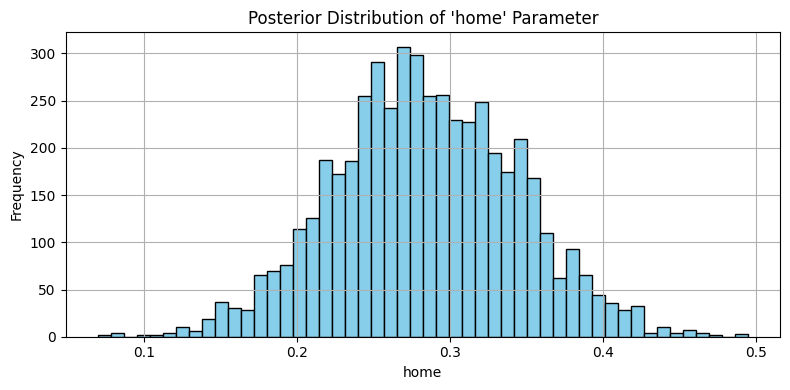

In [15]:
plt.figure(figsize=(8, 4))
plt.hist(samples[:, 0], bins=50, color='skyblue', edgecolor='k')
plt.title("Posterior Distribution of 'home' Parameter")
plt.xlabel("home")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig('home_histogram.png')
plt.show()


## Scatter plot of attack vs defense for teams (posterior means):

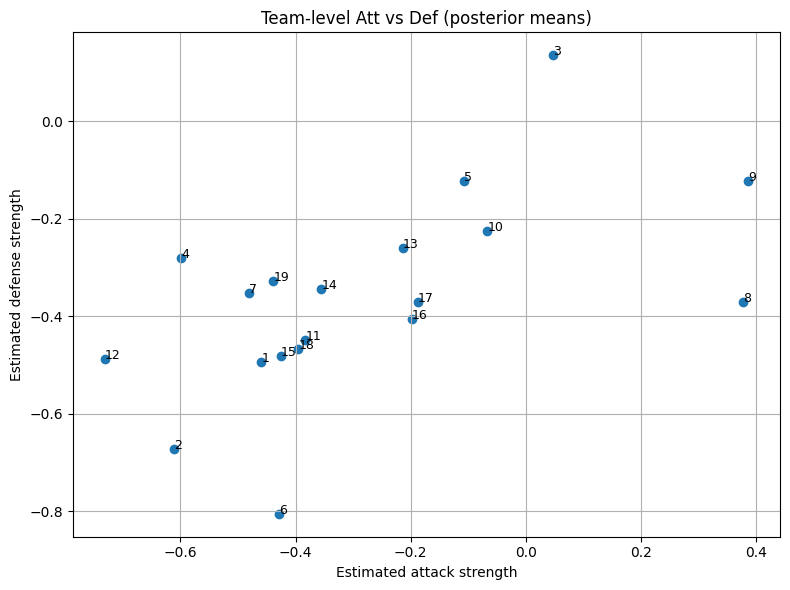

In [16]:
att_samples = samples[:, att_start_idx:def_start_idx]
def_samples = samples[:, def_start_idx:hyper_start_idx]

mean_att = att_samples.mean(axis=0)
mean_def = def_samples.mean(axis=0)

plt.figure(figsize=(8, 6))
plt.scatter(mean_att, mean_def)

for i in range(1, n_teams):
    plt.text(mean_att[i-1], mean_def[i-1], str(i), fontsize=9)

plt.xlabel("Estimated attack strength")
plt.ylabel("Estimated defense strength")
plt.title("Team-level Att vs Def (posterior means)")
plt.grid(True)
plt.tight_layout()
plt.savefig('att_vs_def.png')
plt.show()


Running σ=0.005, t=1
Running σ=0.005, t=5
Running σ=0.005, t=20
Running σ=0.005, t=50
Running σ=0.05, t=1
Running σ=0.05, t=5
Running σ=0.05, t=20
Running σ=0.05, t=50
Running σ=0.5, t=1
Running σ=0.5, t=5
Running σ=0.5, t=20
Running σ=0.5, t=50


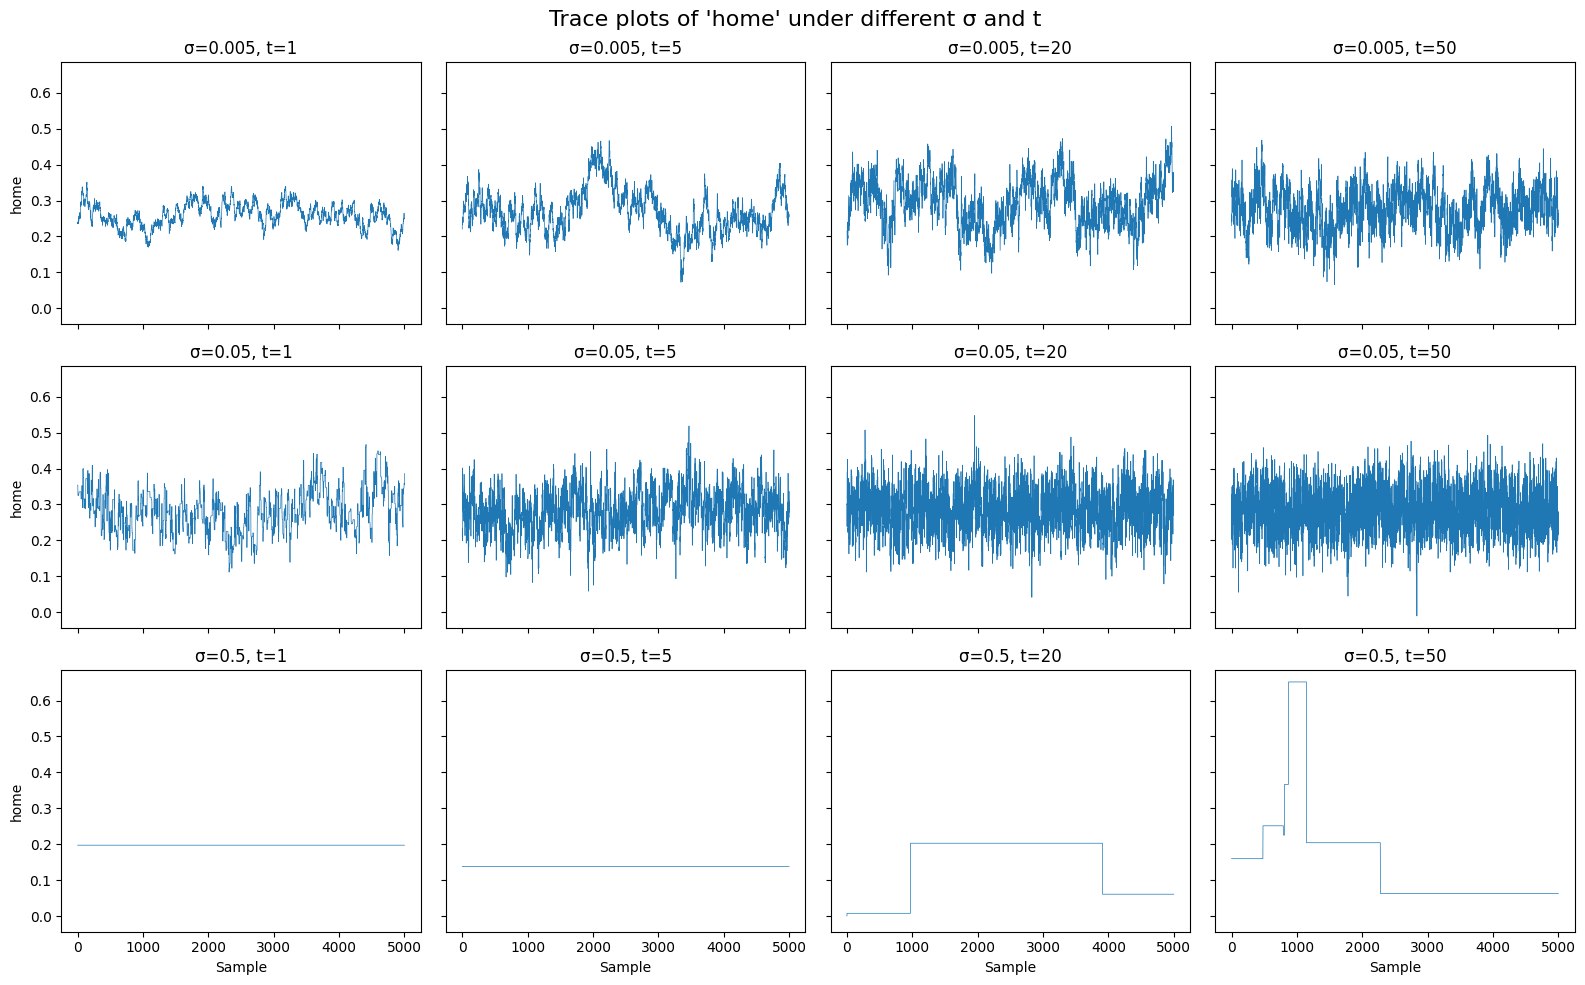


Acceptance Rate Table:

        σ   t  Acceptance Rate (%)
0   0.005   1                89.00
1   0.005   5                89.15
2   0.005  20                89.27
3   0.005  50                89.45
4   0.050   1                20.18
5   0.050   5                18.29
6   0.050  20                17.56
7   0.050  50                17.35
8   0.500   1                 0.02
9   0.500   5                 0.00
10  0.500  20                 0.00
11  0.500  50                 0.00


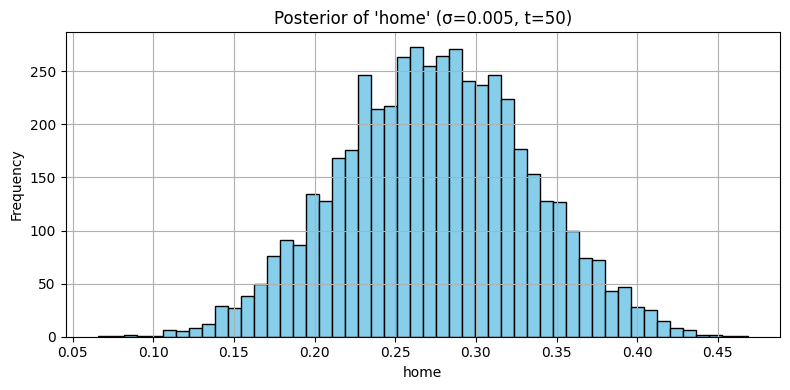

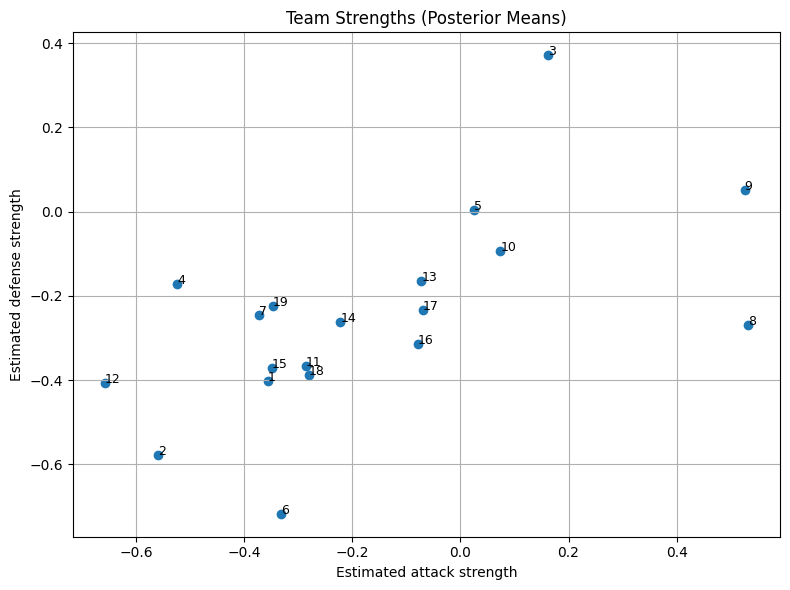

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, gamma, poisson

# Load data
data = np.loadtxt("premier_league_2013_2014.dat", delimiter=",")
y_g1 = data[:, 0]
y_g2 = data[:, 1]
h_g = data[:, 2].astype(int)
a_g = data[:, 3].astype(int)

# Constants
n_teams = 20
tau_0 = 0.0001
tau_1 = 0.0001
alpha = beta = 0.1

att_start_idx = 1
def_start_idx = att_start_idx + (n_teams - 1)
hyper_start_idx = def_start_idx + (n_teams - 1)
n_params = 1 + 2 * (n_teams - 1) + 4

def log_likelihood(params):
    home = params[0]
    att = np.zeros(n_teams)
    att[1:] = params[att_start_idx:def_start_idx]
    def_ = np.zeros(n_teams)
    def_[1:] = params[def_start_idx:hyper_start_idx]
    mu_att, mu_def = params[hyper_start_idx], params[hyper_start_idx + 1]
    tau_att, tau_def = params[hyper_start_idx + 2], params[hyper_start_idx + 3]
    if tau_att <= 0 or tau_def <= 0:
        return -np.inf
    log_theta1 = home + att[h_g] - def_[a_g]
    log_theta2 = att[a_g] - def_[h_g]
    theta1, theta2 = np.exp(log_theta1), np.exp(log_theta2)
    ll = np.sum(poisson.logpmf(y_g1, theta1) + poisson.logpmf(y_g2, theta2))
    ll += norm.logpdf(home, 0, np.sqrt(1 / tau_0))
    ll += np.sum(norm.logpdf(att[1:], mu_att, np.sqrt(1 / tau_att)))
    ll += np.sum(norm.logpdf(def_[1:], mu_def, np.sqrt(1 / tau_def)))
    ll += norm.logpdf(mu_att, 0, np.sqrt(1 / tau_1)) + norm.logpdf(mu_def, 0, np.sqrt(1 / tau_1))
    ll += gamma.logpdf(tau_att, alpha, scale=1 / beta) + gamma.logpdf(tau_def, alpha, scale=1 / beta)
    return ll

def metropolis_hastings(n_burn, n_samples, thin, sigma):
    current = np.zeros(n_params)
    current[hyper_start_idx + 2] = 1.0
    current[hyper_start_idx + 3] = 1.0
    current_ll = log_likelihood(current)
    accepted = 0
    samples = np.zeros((n_samples, n_params))
    home_trace = []

    for i in range(n_burn + n_samples * thin):
        proposal = current + np.random.normal(0, sigma, n_params)
        proposal[hyper_start_idx + 2:] = np.abs(proposal[hyper_start_idx + 2:])
        prop_ll = log_likelihood(proposal)
        log_accept_ratio = prop_ll - current_ll
        if np.log(np.random.rand()) < log_accept_ratio:
            current, current_ll = proposal, prop_ll
            accepted += 1
        if i >= n_burn and (i - n_burn) % thin == 0:
            idx = (i - n_burn) // thin
            samples[idx] = current
            home_trace.append(current[0])
    return samples, np.array(home_trace), accepted / (n_burn + n_samples * thin)

# Run for various σ and thinning t
sigmas = [0.005, 0.05, 0.5]
thins = [1, 5, 20, 50]
n_burn, n_samples = 5000, 5000
results = []

for sigma in sigmas:
    for t in thins:
        print(f"Running σ={sigma}, t={t}")
        samples, home_trace, acc_rate = metropolis_hastings(n_burn, n_samples, t, sigma)
        results.append({
            "σ": sigma, "t": t,
            "acceptance": acc_rate,
            "samples": samples,
            "home_trace": home_trace
        })

# Plot trace plots grid
fig, axes = plt.subplots(len(sigmas), len(thins), figsize=(16, 10), sharex=True, sharey=True)
for i, sigma in enumerate(sigmas):
    for j, t in enumerate(thins):
        idx = i * len(thins) + j
        axes[i, j].plot(results[idx]["home_trace"], linewidth=0.5)
        axes[i, j].set_title(f"σ={sigma}, t={t}")
        if i == len(sigmas) - 1: axes[i, j].set_xlabel("Sample")
        if j == 0: axes[i, j].set_ylabel("home")
plt.suptitle("Trace plots of 'home' under different σ and t", fontsize=16)
plt.tight_layout()
plt.savefig("bonus_trace_grid.png")
plt.show()

# Print acceptance rate table
acceptance_table = pd.DataFrame([{
    "σ": r["σ"], "t": r["t"], "Acceptance Rate (%)": round(r["acceptance"] * 100, 2)
} for r in results])
print("\nAcceptance Rate Table:\n")
print(acceptance_table)

# Select best setting (highest acceptance)
best = max(results, key=lambda r: r["acceptance"])

# Plot posterior histogram of 'home'
plt.figure(figsize=(8, 4))
plt.hist(best["home_trace"], bins=50, color='skyblue', edgecolor='k')
plt.title(f"Posterior of 'home' (σ={best['σ']}, t={best['t']})")
plt.xlabel("home")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.savefig("bonus_home_hist.png")
plt.show()

# Plot att vs def means
att_samples = best["samples"][:, att_start_idx:def_start_idx]
def_samples = best["samples"][:, def_start_idx:hyper_start_idx]
mean_att = att_samples.mean(axis=0)
mean_def = def_samples.mean(axis=0)

plt.figure(figsize=(8, 6))
plt.scatter(mean_att, mean_def)
for i in range(1, n_teams):
    plt.text(mean_att[i - 1], mean_def[i - 1], str(i), fontsize=9)
plt.xlabel("Estimated attack strength")
plt.ylabel("Estimated defense strength")
plt.title("Team Strengths (Posterior Means)")
plt.grid(True)
plt.tight_layout()
plt.savefig("bonus_att_vs_def.png")
plt.show()
